In [2]:
import os
import sys
import numpy as np
import sympy as sp
import torch as pt
from torch.nn.functional import normalize
import scipy
from tqdm import tqdm
import random
from sklearn.model_selection import train_test_split
import logging
import sys
from torch.utils.data import TensorDataset, DataLoader
from torch.func import hessian, vmap
from torch.optim.lr_scheduler import ReduceLROnPlateau

device = pt.device("cuda" if pt.cuda.is_available() else "cpu")

sys.path.append(os.path.abspath('../../'))

from src.useful_functions import *
from src.data_modules.PWDs_module import generate_PWDistances_torch
from src.data_modules.sqra_functions import*
from src.data_modules.openmm_functions import*
from src.isokann.isokann_modules4 import*
# For reproducibility
np.random.seed(0)


# Read directory paths
read_dirs_paths('../dir_paths.txt', globals())



 
Created variables:
inp_dir = /scratch/htc/fsafarov/2cm2_simulation/md2/input/
dcd_dir = /scratch/htc/fsafarov/2cm2_simulation/md2/output/trajectories/openmm_files
out_dir = /scratch/htc/fsafarov/ISOKANN_PINN/output/


In [3]:
forces = pt.load(os.path.join(out_dir, 'forces_kb8_ca.pt'))
positions = pt.load(os.path.join(out_dir, 'positions_kb8_ca.pt'))

In [4]:
# mean_forces = forces.mean(dim=-1, keepdim=True)
# std_forces = forces.std(dim=-1, keepdim=True)
# forces_normalized = (forces - mean_forces)/(std_forces + 1e-8)

In [ ]:
inp_dim = positions.shape[-1]
nodes = [inp_dim, 256, 128, 64, 1] 
base_mlp = MLP(nodes, act_fun='softplus')

In [ ]:
model = ratesNN(base_mlp)
# optimizer = pt.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
optimizer = pt.optim.SGD(model.parameters(), lr=1e-5, weight_decay=1e-5, momentum=0.85, nesterov=True)
# optimizer = pt.optim.SGD([
#     {'params': model.net.parameters(), 'lr': 1e-4},
#     {'params': [model.c1_, model.c2_], 'lr': 1e-3}
# ], weight_decay=1e-5, momentum=0.85, nesterov=True)

# optimizer = pt.optim.SGD([
#     {'params': model.net.parameters(), 'lr': 1e-4},
#     {'params': [model.c1_, model.c2_], 'lr': 1e-3}
# ], weight_decay=1e-5)

# optimizer = pt.optim.Adam([
#     {'params': model.net.parameters(), 'lr': 1e-4},
#     {'params': [model.c1_, model.c2_], 'lr': 1e-3}
# ], weight_decay=1e-5)



c1_vals, c2_vals = trainNN(
    model=model, 
    coords=positions.to(device), 
    forces_fn=forces.to(device), 
    batch_size=500,
    optimizer=optimizer, 
    Nepochs=1000,
    lam_bound=10,
    device=device
)

epoch   0 | loss 0.003983 |
epoch 125 | loss 0.000001 |
epoch 250 | loss 0.000000 |
epoch 375 | loss 0.000000 |
epoch 500 | loss 0.000000 |
epoch 625 | loss 0.000000 |
epoch 750 | loss 0.000000 |
epoch 875 | loss 0.000000 |
epoch 1000 | loss 0.000000 |


In [7]:
with pt.no_grad():
    chi = model(positions.to(device))


In [8]:
def scale_and_shift(y):
    minarr = pt.min(y)
    maxarr = pt.max(y)
    hat_y =  (y - minarr) / (maxarr - minarr)

    return hat_y

chi_s = scale_and_shift(chi)

In [9]:
chi_s = chi_s.squeeze(-1).cpu().detach().numpy()



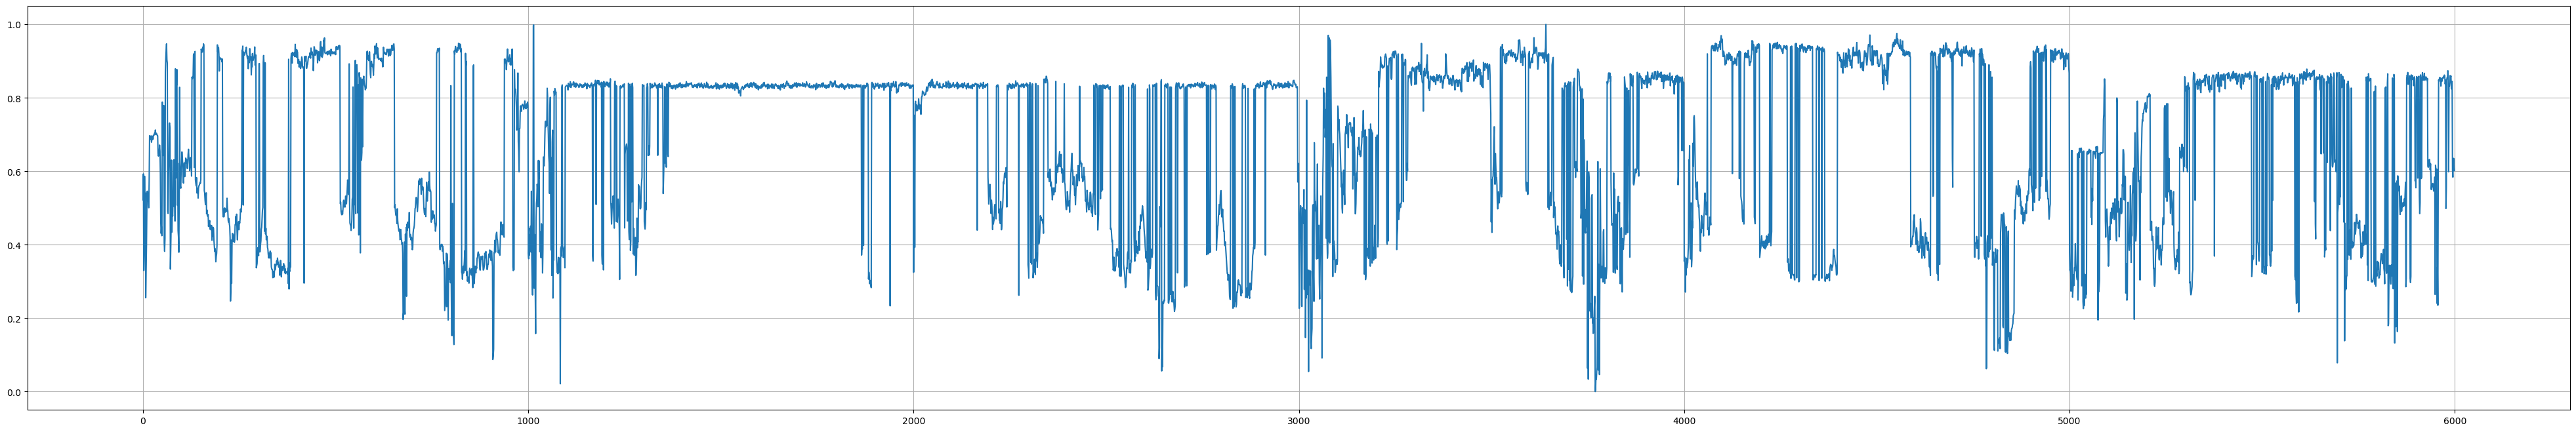

In [21]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(50,8))
plt.plot(chi_s)
plt.grid()

In [11]:
del forces
del positions

In [12]:
np.savetxt(os.path.join(out_dir, 'chi_0.txt'), chi_s)

In [13]:
chi0 = np.loadtxt('/scratch/htc/fsafarov/2cm2_simulation/md2/output/isokann/outs_26/' + 'chi0_lr.txt')
chi_m = np.array([chi0, chi_s])

In [14]:
from scipy.linalg import svd
U, S, V = svd(chi_m)

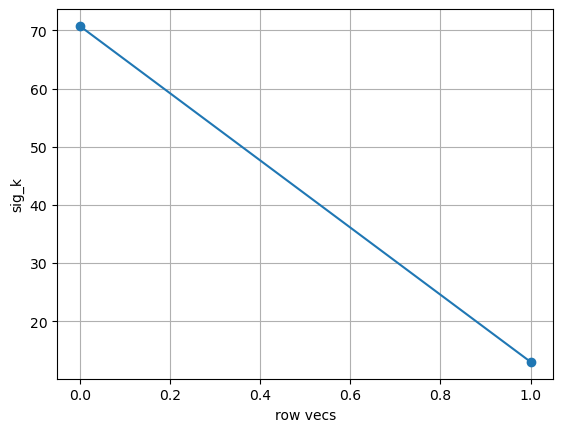

In [15]:
plt.plot(S, 'o-')
plt.xlabel('row vecs')
plt.ylabel('sig_k')
plt.grid()

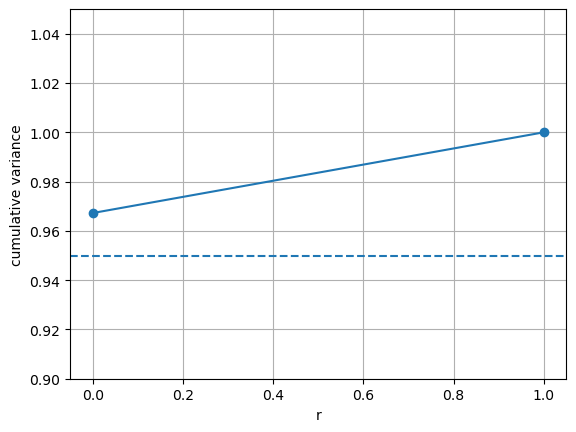

In [16]:
varfrac = (S**2)/np.sum(S**2)
plt.plot(np.cumsum(varfrac), 'o-'); plt.axhline(0.95, ls='--');
plt.xlabel('r')
plt.ylabel('cumulative variance')
plt.ylim(0.9, 1.05)
plt.grid()

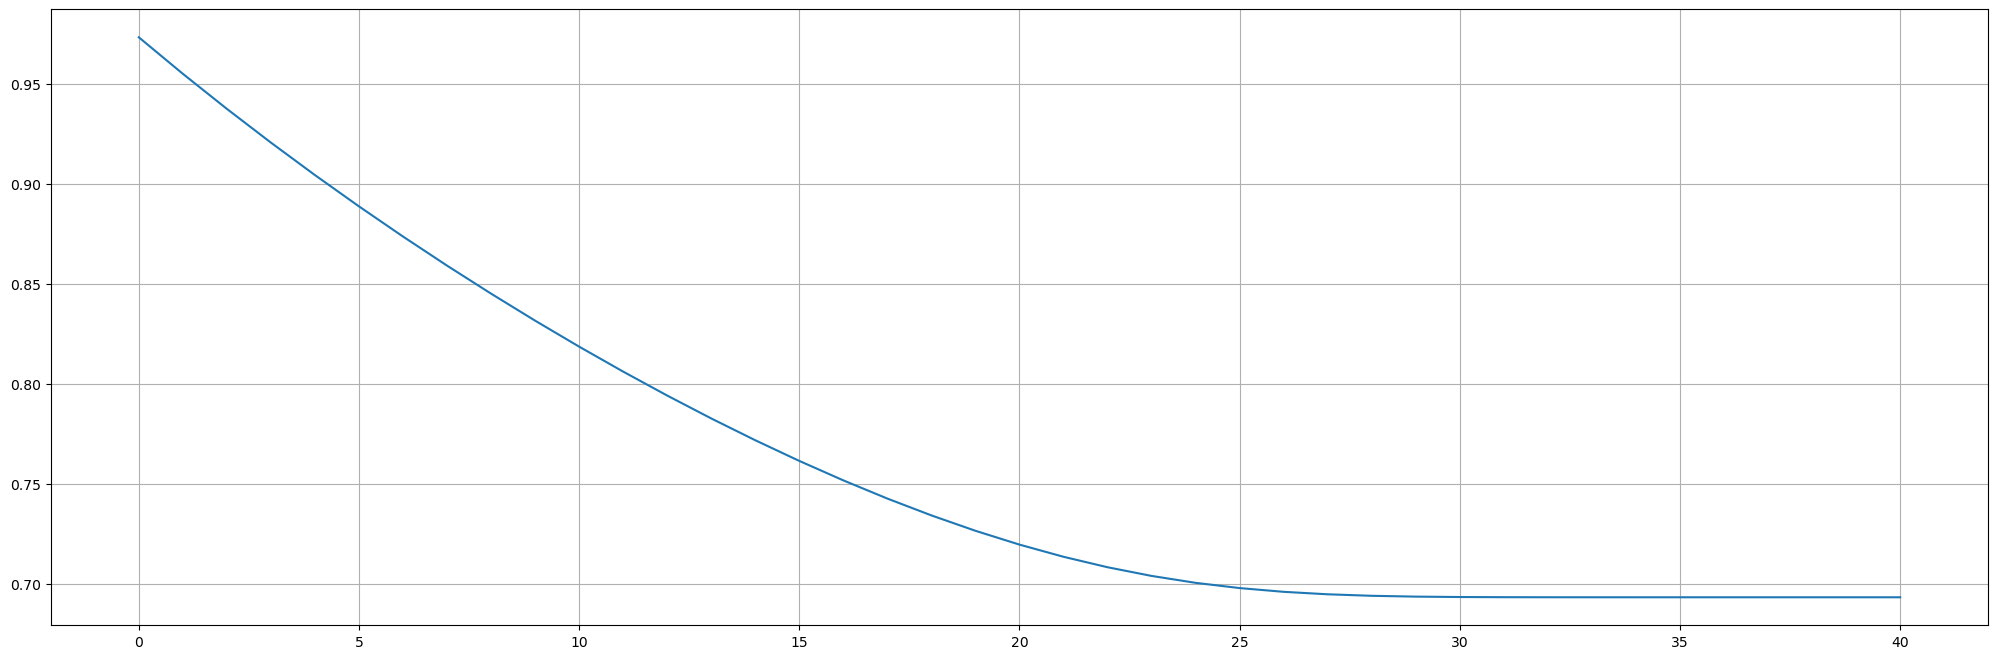

In [17]:
plt.figure(figsize=(25,8))
plt.plot(c2_vals)
plt.grid()